In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import apply_cats, proc_df
from fastai.column_data import *
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import dill as pickle
from IPython.display import display

pd.options.display.max_columns = None
import numpy as np
np.set_printoptions(threshold=50, edgeitems=20)
data_path=Path('data/')
PATH = data_path
SK_ID_CURR = "SK_ID_CURR"

# TODOS:

Try to fix overfitting - by remove extra information

In [3]:
cred_card_bal = pickle.load(open('data/credit_card_balance','rb'))
pos_cash_bal = pickle.load(open('data/POS_CASH_balance','rb'))
prev = pickle.load(open('data/previous_application','rb'))
bureau_bal = pickle.load(open('data/bureau_balance','rb'))
install = pickle.load(open('data/installments_payments','rb'))
bureau = pickle.load(open('data/bureau','rb'))
application_train = pickle.load(open('data/application_train','rb'))
application_test = pickle.load(open('data/application_test','rb'))

In [4]:
merged_df = pickle.load(open('data/merged_df.pickle','rb'))

In [5]:
len(merged_df.columns)

213

In [6]:
prev.sample(10)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
101181,1983434,342318,Revolving loans,9000.000,180000.0,180000.0,NaN,180000.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XAP,Refused,-308,XNA,HC,Unaccompanied,Repeater,XNA,Cards,x-sell,Credit and cash offices,150,XNA,0.0,XNA,Card X-Sell,NaN,NaN,NaN,NaN,NaN,NaN
1069586,1184538,209276,Consumer loans,6606.855,146493.0,146493.0,0.0,146493.0,SUNDAY,12,Y,1,0.000000,NaN,NaN,XAP,Approved,-1599,Cash through the bank,XAP,Unaccompanied,New,Consumer Electronics,POS,XNA,Country-wide,500,Consumer electronics,24.0,low_action,POS household without interest,365243.0,-1567.0,-877.0,-877.0,-871.0,0.0
1197638,1408118,377013,Cash loans,NaN,0.0,0.0,NaN,NaN,SATURDAY,11,Y,1,NaN,NaN,NaN,XNA,Canceled,-252,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
1062393,1307511,181472,Consumer loans,7691.895,57060.0,55435.5,5850.0,57060.0,SATURDAY,17,Y,1,0.103959,NaN,NaN,XAP,Approved,-1736,Cash through the bank,XAP,NaN,New,Mobile,POS,XNA,Country-wide,105,Connectivity,10.0,high,POS mobile with interest,365243.0,-1693.0,-1423.0,-1513.0,-1511.0,0.0
310324,1169607,429742,Revolving loans,NaN,0.0,0.0,NaN,NaN,MONDAY,17,Y,1,NaN,NaN,NaN,XAP,Canceled,-457,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Card Street,NaN,NaN,NaN,NaN,NaN,NaN
574497,2256583,415668,Revolving loans,2250.000,45000.0,45000.0,NaN,45000.0,SUNDAY,16,Y,1,NaN,NaN,NaN,XAP,Approved,-467,XNA,XAP,NaN,Repeater,XNA,Cards,walk-in,Country-wide,500,Consumer electronics,0.0,XNA,Card Street,-454.0,-427.0,365243.0,365243.0,365243.0,0.0
21251,2045343,226390,Consumer loans,4422.780,29065.5,27886.5,2907.0,29065.5,SUNDAY,13,Y,1,0.102813,NaN,NaN,XAP,Approved,-2450,Cash through the bank,XAP,Family,New,Mobile,POS,XNA,Country-wide,28,Connectivity,8.0,low_normal,POS mobile with interest,365243.0,-2415.0,-2205.0,-2205.0,-2198.0,1.0
1477246,1586378,329254,Cash loans,56769.435,1372500.0,1470330.0,NaN,1372500.0,SUNDAY,10,Y,1,NaN,NaN,NaN,XNA,Approved,-294,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,36.0,low_normal,Cash X-Sell: low,365243.0,-264.0,786.0,365243.0,365243.0,1.0
656525,2659835,400045,Consumer loans,5368.635,119038.5,119038.5,0.0,119038.5,SUNDAY,5,Y,1,0.000000,NaN,NaN,XAP,Approved,-1585,Cash through the bank,XAP,Unaccompanied,Refreshed,Audio/Video,POS,XNA,Country-wide,1759,Consumer electronics,24.0,low_action,POS household without interest,365243.0,-1554.0,-864.0,-1014.0,-1011.0,0.0
428022,1450151,423395,Consumer loans,18753.120,84861.0,99751.5,0.0,84861.0,WEDNESDAY,12,Y,1,0.000000,NaN,NaN,XAP,Approved,-465,Cash through the bank,XAP,NaN,New,Consumer Electronics,POS,XNA,Country-wide,160,Consumer electronics,6.0,middle,POS household with interest,365243.0,-434.0,-284.0,-314.0,-307.0,0.0


In [7]:
def most_recent_sk_id(curr_sk_id):
    columns = prev[prev["SK_ID_CURR"] == curr_sk_id]
    most_recent_loan = columns[columns["DAYS_DECISION"] == max(columns["DAYS_DECISION"])]
    recent_prev_sk_id = list(most_recent_loan["SK_ID_PREV"])[0]
    return recent_prev_sk_id

In [8]:
largest_idx = prev.groupby(["SK_ID_CURR"], sort=False)['DAYS_DECISION'].idxmax()

In [9]:
def get_most_recent(prev_df):
    largest_idx = prev_df.groupby(["SK_ID_CURR"], sort=False)['DAYS_DECISION'].idxmax()
    return prev_df[prev_df.index.isin(largest_idx.values)]

In [10]:
# prev.describe().T

In [11]:
most_recent = get_most_recent(prev)

In [12]:
len(most_recent)

338857

In [124]:
joined_df = pd.merge(merged_df, most_recent, how='left', on=['SK_ID_CURR'], suffixes=["", "_add_1"])

In [194]:
joined_df[['DAYS_ID_PUBLISH', 'DAYS_BIRTH', 'DAYS_EMPLOYED']] = joined_df.loc[:, ['DAYS_ID_PUBLISH', 'DAYS_BIRTH', 'DAYS_EMPLOYED']].replace([365243], value=0)

In [200]:
joined_df[joined_df["SK_ID_CURR"] == 365243]

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,EMERGENCYSTATE_MODE,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_EMAIL,FLAG_EMP_PHONE,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLOORSMAX_MODE,FLOORSMIN_AVG,FLOORSMIN_MEDI,FLOORSMIN_MODE,FONDKAPREMONT_MODE,HOUR_APPR_PROCESS_START,HOUSETYPE_MODE,LANDAREA_AVG,LANDAREA_MEDI,LANDAREA_MODE,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,LIVINGAREA_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,NAME_TYPE_SUITE,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_AVG,NONLIVINGAREA_MEDI,NONLIVINGAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE,ORGANIZATION_TYPE,OWN_CAR_AGE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,SK_ID_CURR,TARGET,TOTALAREA_MODE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE,PREV APP COUNT,TOTAL PREV LOAN AMT,SK_ID_PREV,AMT_ANNUITY_PAVG,AMT_APPLICATION,AMT_CREDIT_PAVG,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE_PAVG,HOUR_APPR_PROCESS_START_PAVG,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,NAME_CONTRACT_TYPE_BAVG,WEEKDAY_APPR_PROCESS_START_BAVG,FLAG_LAST_APPL_PER_CONTRACT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE_BAVG,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION,SK_ID_PREV_CCAVG,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF,NAME_CONTRACT_STATUS_CCAVG,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_BAVG,MONTHS_BALANCE_B_B,STATUS,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD_CAVG,SK_DPD_DEF_CAVG,NAME_CONTRACT_STATUS_CAVG,SK_ID_PREV_IAVG,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,SK_ID_CURR_CNT_BUREAU,SK_ID_CURR_CNT_CRED_CARD,SK_ID_CURR_CNT_POS_CASH,SK_ID_CURR_CNT_INSTALL,SK_ID_PREV_add_1,NAME_C

In [201]:
joined_df[['DAYS_ID_PUBLISH', 'DAYS_BIRTH', 'DAYS_EMPLOYED']]

,DAYS_ID_PUBLISH,DAYS_BIRTH,DAYS_EMPLOYED
0,-2120,-9461,-637
1,-291,-16765,-1188
2,-2531,-19046,-225
3,-2437,-19005,-3039
4,-3458,-19932,-3038
5,-477,-16941,-1588
6,-619,-13778,-3130
7,-2379,-18850,-449
8,-3514,-20099,0
9,-3992,-14469,-2019


In [202]:
train_df = joined_df.loc[joined_df[SK_ID_CURR].isin(application_train[SK_ID_CURR])]

In [203]:
test_df = joined_df.loc[joined_df[SK_ID_CURR].isin(application_test[SK_ID_CURR])]

In [204]:
len(train_df)

307511

In [205]:
len(application_train)

307511

In [206]:
assert(len(train_df) == len(application_train))

In [207]:
assert(len(test_df) == len(application_test))

In [219]:
len(train_df.columns)

249

In [220]:
samp_size = len(train_df)

In [221]:
train_ratio  = 0.75
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(train_df)))

In [222]:
val_idx[:10]

[230633,
 230634,
 230635,
 230636,
 230637,
 230638,
 230639,
 230640,
 230641,
 230642]

In [223]:
column_type_map = joined_df.columns.to_series().groupby(joined_df.dtypes).groups

In [224]:
dtype_int64, dtype_float64, dtype_o = column_type_map.keys()

In [225]:
column_type_map[dtype_int64]

Index(['CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH',
       'FLAG_CONT_MOBILE', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
       'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
       'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_2',
       'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_EMAIL',
       'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_PHONE', 'FLAG_WORK_PHONE',
       'HOUR_APPR_PROCESS_START', 'LIVE_CITY_NOT_WORK_CITY',
       'LIVE_REGION_NOT_WORK_REGION', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'SK_ID_CURR'],
      dtype='object')

In [226]:
column_type_map[dtype_o]

Index(['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE',
       'ORGANIZATION_TYPE', 'WALLSMATERIAL_MODE', 'WEEKDAY_APPR_PROCESS_START',
       'NAME_CONTRACT_TYPE_BAVG', 'WEEKDAY_APPR_PROCESS_START_BAVG',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON',
       'NAME_TYPE_SUITE_BAVG', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY',
       'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE',
       'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'NAME_CONTRACT_STATUS_CCAVG', 'STATUS', 'NAME_CONTRACT_STATUS_CAVG',
       'NAME_CONTRACT_TYPE_add_1', 'WEEKDAY_APPR_PROCESS_START_add_1',
       'FLAG_LAST_APPL_PER_CONTRACT_add_1', 'NAME_CASH_LOAN_PURPOSE_a

In [227]:
cat_vars  = list(set(column_type_map[dtype_int64])) + list(set(column_type_map[dtype_o]))

In [228]:
days = []
for var in cat_vars:
    if "DAYS" in var:
        days.append(var)

In [229]:
days

['DAYS_ID_PUBLISH', 'DAYS_BIRTH', 'DAYS_EMPLOYED']

In [230]:
not_cat = ["SK_ID_CURR"] + days

In [231]:
not_cat

['SK_ID_CURR', 'DAYS_ID_PUBLISH', 'DAYS_BIRTH', 'DAYS_EMPLOYED']

In [232]:
cat_vars = list(set(cat_vars) - set(not_cat))

In [233]:
cat_vars = list(set(cat_vars) - set(days))

In [234]:
cat_vars

['CODE_GENDER',
 'FLAG_DOCUMENT_18',
 'NAME_CASH_LOAN_PURPOSE_add_1',
 'FLAG_DOCUMENT_5',
 'PRODUCT_COMBINATION_add_1',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_8',
 'NAME_TYPE_SUITE',
 'FLAG_DOCUMENT_4',
 'NAME_CLIENT_TYPE',
 'FLAG_DOCUMENT_14',
 'NAME_CONTRACT_STATUS',
 'NAME_CONTRACT_TYPE_BAVG',
 'FLAG_DOCUMENT_15',
 'NAME_PAYMENT_TYPE_add_1',
 'OCCUPATION_TYPE',
 'NAME_TYPE_SUITE_add_1',
 'CODE_REJECT_REASON',
 'NAME_CONTRACT_STATUS_CAVG',
 'FLAG_DOCUMENT_21',
 'FLAG_DOCUMENT_12',
 'FLAG_WORK_PHONE',
 'NAME_PORTFOLIO_add_1',
 'NAME_PORTFOLIO',
 'WEEKDAY_APPR_PROCESS_START_BAVG',
 'WALLSMATERIAL_MODE',
 'NAME_YIELD_GROUP_add_1',
 'REGION_RATING_CLIENT_W_CITY',
 'NAME_SELLER_INDUSTRY_add_1',
 'CODE_REJECT_REASON_add_1',
 'NAME_CASH_LOAN_PURPOSE',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'FLAG_DOCUMENT_13',
 'REG_CITY_NOT_WORK_CITY',
 'CHANNEL_TYPE',
 'NAME_HOUSING_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'NAME_CONTRACT_STATUS_CCAVG',
 'FLAG_OWN_REALTY',
 'NAME_PRODUCT_TYPE_add_

In [235]:
contin_vars = list(set(column_type_map[dtype_float64])) + not_cat

In [236]:
not_cat

['SK_ID_CURR', 'DAYS_ID_PUBLISH', 'DAYS_BIRTH', 'DAYS_EMPLOYED']

In [237]:
contin_vars

['EXT_SOURCE_2',
 'AMT_CREDIT_LIMIT_ACTUAL',
 'LIVINGAPARTMENTS_MODE',
 'MONTHS_BALANCE',
 'TARGET',
 'SK_ID_CURR_CNT_BUREAU',
 'BASEMENTAREA_MEDI',
 'FLOORSMAX_MODE',
 'SELLERPLACE_AREA_add_1',
 'NONLIVINGAPARTMENTS_AVG',
 'DAYS_TERMINATION_add_1',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'LIVINGAREA_MODE',
 'AMT_PAYMENT_CURRENT',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_FIRST_DUE',
 'DAYS_ENTRY_PAYMENT',
 'AMT_ANNUITY_BAVG',
 'FLOORSMIN_MODE',
 'AMT_APPLICATION',
 'SK_ID_PREV_IAVG',
 'NONLIVINGAREA_AVG',
 'COMMONAREA_AVG',
 'YEARS_BEGINEXPLUATATION_MODE',
 'DAYS_ENDDATE_FACT',
 'AMT_ANNUITY_add_1',
 'AMT_PAYMENT',
 'CREDIT_DAY_OVERDUE',
 'NONLIVINGAPARTMENTS_MODE',
 'AMT_DOWN_PAYMENT_add_1',
 'CNT_INSTALMENT_FUTURE',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'SK_ID_CURR_CNT_INSTALL',
 'DAYS_TERMINATION',
 'AMT_CREDIT_SUM_DEBT',
 'SK_DPD_CAVG',
 'EXT_SOURCE_1',
 'AMT_RECIVABLE',
 'AMT_CREDIT_SUM_LIMIT',
 'AMT_GOODS_PRICE_add_1',
 'BASEMENTAREA_AVG'

In [238]:
for v in cat_vars:
    train_df[v] = train_df[v].astype('category')
    test_df[v] = test_df[v].astype('category')

/home/cheeseblubber/anaconda3/envs/fastai-latest/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/cheeseblubber/anaconda3/envs/fastai-latest/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [239]:
for v in contin_vars:
    train_df[v] = train_df[v].fillna(0).astype('float32')
    test_df[v] = test_df[v].fillna(0).astype('float32')

/home/cheeseblubber/anaconda3/envs/fastai-latest/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/cheeseblubber/anaconda3/envs/fastai-latest/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [240]:
cat_sz = [(c, len(train_df[c].cat.categories)+1) for c in cat_vars]

In [241]:
apply_cats(test_df, train_df)

/home/cheeseblubber/workspace/competition/home-default-credit/fastai/structured.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[n] = pd.Categorical(c, categories=trn[n].cat.categories, ordered=True)


In [242]:
cat_sz

[('CODE_GENDER', 4),
 ('FLAG_DOCUMENT_18', 3),
 ('NAME_CASH_LOAN_PURPOSE_add_1', 26),
 ('FLAG_DOCUMENT_5', 3),
 ('PRODUCT_COMBINATION_add_1', 18),
 ('FLAG_DOCUMENT_9', 3),
 ('FLAG_DOCUMENT_19', 3),
 ('FLAG_DOCUMENT_8', 3),
 ('NAME_TYPE_SUITE', 8),
 ('FLAG_DOCUMENT_4', 3),
 ('NAME_CLIENT_TYPE', 5),
 ('FLAG_DOCUMENT_14', 3),
 ('NAME_CONTRACT_STATUS', 5),
 ('NAME_CONTRACT_TYPE_BAVG', 5),
 ('FLAG_DOCUMENT_15', 3),
 ('NAME_PAYMENT_TYPE_add_1', 5),
 ('OCCUPATION_TYPE', 19),
 ('NAME_TYPE_SUITE_add_1', 8),
 ('CODE_REJECT_REASON', 10),
 ('NAME_CONTRACT_STATUS_CAVG', 8),
 ('FLAG_DOCUMENT_21', 3),
 ('FLAG_DOCUMENT_12', 3),
 ('FLAG_WORK_PHONE', 3),
 ('NAME_PORTFOLIO_add_1', 6),
 ('NAME_PORTFOLIO', 6),
 ('WEEKDAY_APPR_PROCESS_START_BAVG', 8),
 ('WALLSMATERIAL_MODE', 8),
 ('NAME_YIELD_GROUP_add_1', 6),
 ('REGION_RATING_CLIENT_W_CITY', 4),
 ('NAME_SELLER_INDUSTRY_add_1', 12),
 ('CODE_REJECT_REASON_add_1', 10),
 ('NAME_CASH_LOAN_PURPOSE', 26),
 ('FLAG_LAST_APPL_PER_CONTRACT', 3),
 ('FLAG_DOCUMENT_13',

In [243]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [244]:
proc_train_df, y, _, mapper = proc_df(train_df, y_fld="TARGET", skip_flds=["SK_ID_CURR", "SK_ID_PREV"], do_scale=True)

/home/cheeseblubber/anaconda3/envs/fastai-latest/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [245]:
proc_test_df, _, nas, mapper = proc_df(test_df, do_scale=True, mapper=mapper)

/home/cheeseblubber/anaconda3/envs/fastai-latest/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [246]:
bs = 1000

In [247]:
y[:10]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [248]:
len(proc_test_df.columns)

249

In [249]:
proc_test_df.drop(columns=["TARGET"], inplace=True)

In [250]:
proc_train_df.to_pickle("data/train_df1")
proc_test_df.to_pickle("data/test_df1")

In [251]:
test_df["TARGET"]

307511    0.0
307512    0.0
307513    0.0
307514    0.0
307515    0.0
307516    0.0
307517    0.0
307518    0.0
307519    0.0
307520    0.0
307521    0.0
307522    0.0
307523    0.0
307524    0.0
307525    0.0
307526    0.0
307527    0.0
307528    0.0
307529    0.0
307530    0.0
307531    0.0
307532    0.0
307533    0.0
307534    0.0
307535    0.0
307536    0.0
307537    0.0
307538    0.0
307539    0.0
307540    0.0
         ... 
356225    0.0
356226    0.0
356227    0.0
356228    0.0
356229    0.0
356230    0.0
356231    0.0
356232    0.0
356233    0.0
356234    0.0
356235    0.0
356236    0.0
356237    0.0
356238    0.0
356239    0.0
356240    0.0
356241    0.0
356242    0.0
356243    0.0
356244    0.0
356245    0.0
356246    0.0
356247    0.0
356248    0.0
356249    0.0
356250    0.0
356251    0.0
356252    0.0
356253    0.0
356254    0.0
Name: TARGET, Length: 48744, dtype: float32

In [252]:
"TARGET" in list(proc_train_df.columns)

False

In [253]:
list(set(proc_test_df.columns) - set(proc_train_df.columns))

['SK_ID_CURR', 'SK_ID_PREV']

In [254]:
len(proc_test_df.columns)

248

In [255]:
proc_test_df.drop(columns=["SK_ID_PREV", "SK_ID_CURR"], inplace=True)

In [256]:
joined_df[['DAYS_BIRTH', 'DAYS_EMPLOYED']]

,DAYS_BIRTH,DAYS_EMPLOYED
0,-9461,-637
1,-16765,-1188
2,-19046,-225
3,-19005,-3039
4,-19932,-3038
5,-16941,-1588
6,-13778,-3130
7,-18850,-449
8,-20099,0
9,-14469,-2019


In [257]:
proc_test_df[['DAYS_BIRTH', 'DAYS_EMPLOYED']]

,DAYS_BIRTH,DAYS_EMPLOYED
307511,-0.734193,-0.162176
307512,-0.464485,-1.089762
307513,-0.916824,-1.084994
307514,0.472274,0.038511
307515,0.686757,-0.102360
307516,-0.588225,-4.357983
307517,-0.148489,-0.270973
307518,1.494277,0.246134
307519,0.754585,0.408245
307520,1.292855,-0.290478


In [258]:
md = ColumnarModelData.from_data_frame(
    PATH, val_idx, proc_train_df, y.astype(np.int32), 
    cat_flds=cat_vars, bs=bs, is_reg=False, test_df=proc_test_df,
    is_multi=False
)

In [259]:
m = md.get_learner(emb_szs, len(proc_train_df.columns)-len(cat_vars), 0.1, 2, [50,30], drops=[0.25, 0.20])

In [260]:
m.lr_find()

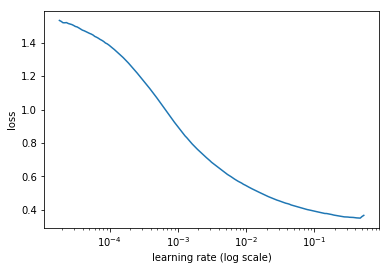

In [261]:
m.sched.plot()

In [262]:
lr = 1e-2

In [263]:
m.fit(lr, 1, cycle_len=2)

epoch      trn_loss   val_loss                               
    0      0.277984   0.251371  
    1      0.262404   0.248944                               


[array([0.24894])]

In [264]:
m.fit(lr, 2, cycle_len=2)

epoch      trn_loss   val_loss                               
    0      0.253966   0.246991  
    1      0.252484   0.245023                               
    2      0.251351   0.245608                               
    3      0.249365   0.244778                               


[array([0.24478])]

In [265]:
m.fit(lr/2, 5, wds=1e-7, cycle_len=3, best_save_name="best_home_default1")

epoch      trn_loss   val_loss                               
    0      0.248267   0.244826  
    1      0.247477   0.244                                  
    2      0.247546   0.244263                               
    3      0.249406   0.245032                               
    4      0.246971   0.244501                               
    5      0.244097   0.244199                               
    6      0.249912   0.244821                               
    7      0.244025   0.244681                               
    8      0.246131   0.244499                               
    9      0.248787   0.244806                               
    10     0.244834   0.244452                               
    11     0.242687   0.244606                               
    12     0.248158   0.245207                               
    13     0.243537   0.245261                               
    14     0.240403   0.245114                               


[array([0.24511])]

In [266]:
m.load(name="best_home_default1")

In [267]:
m.fit(lr/10, 2, cycle_len=2, wds=1e-7, best_save_name="best_home_default2")

epoch      trn_loss   val_loss                               
    0      0.246314   0.244366  
    1      0.247674   0.244315                               
    2      0.243379   0.244324                               
    3      0.24706    0.244115                               


[array([0.24412])]

In [268]:
m.load(name="best_home_default2")

In [270]:
m.fit(lr/20, 3, cycle_len=2, wds=1e-7, best_save_name="best_home_default3")

epoch      trn_loss   val_loss                               
    0      0.246167   0.244301  
    1      0.243147   0.244194                               
    2      0.248095   0.244318                               
    3      0.240509   0.24424                                
    4      0.246029   0.244218                               
    5      0.244749   0.244217                               


[array([0.24422])]

In [269]:
pred_test=m.predict(True)

In [109]:
pred_test = np.exp(pred_test)

In [110]:
pred_test[:,0]

array([0.94453, 0.80775, 0.96143, 0.92495, 0.81945, 0.93728, 0.9937 , 0.9389 , 0.98859, 0.89904, 0.95811,
       0.93979, 0.83626, 0.98165, 0.96304, 0.86035, 0.95172, 0.9863 , 0.87585, 0.93692, ..., 0.91261,
       0.94857, 0.96386, 0.97293, 0.98493, 0.90118, 0.86932, 0.98954, 0.90076, 0.96551, 0.93612, 0.95867,
       0.97562, 0.87737, 0.95709, 0.976  , 0.9146 , 0.9576 , 0.94769, 0.82164], dtype=float32)

(array([    1.,     0.,     3.,    52.,   272.,   672.,  1384.,  3347., 10552., 32461.]),
 array([0.16914, 0.25223, 0.33531, 0.4184 , 0.50149, 0.58457, 0.66766, 0.75074, 0.83383, 0.91691, 1.     ]),
 <a list of 10 Patch objects>)

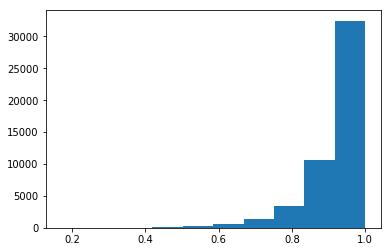

In [111]:
matplotlib.pyplot.hist(pred_test[:,0])

In [112]:
application_test['TARGET']=pred_test[:,1]

In [116]:
csv_fn=f'{PATH}/tmp/sub7.csv'

In [117]:
application_test['SK_ID_CURR'] = application_test['SK_ID_CURR'].astype(int)

In [118]:
application_test[['SK_ID_CURR','TARGET']].to_csv(csv_fn, index=False)

In [119]:
FileLink(csv_fn)

/home/cheeseblubber/workspace/competition/home-default-credit/data/tmp/sub7.csv